# Troubleshooting for why "n_levels" changes result
## Start with lithium1.ipynb and change all parameters one by one

In [118]:
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from IPython.display import Math, display
from matplotlib.axes import Axes
from scipy import constants as const
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.signal import argrelmax,argrelmin
from tqdm import tqdm

import fewfermions.analysis.units as si
from fewfermions.simulate.traps.twod.trap import PancakeTrap
from fewfermions.style import FIGS_PATH, setup

colors, colors_alpha = setup()

### original lithium1 code (adjust initial power to see 0 bound states), (n_levels=60 to check for bug)

In [22]:
initial_power = 260 * si.uW

#parameters for lithium setup
wvl = 1064 * si.nm
omega_l = 2 * np.pi * const.c / wvl
omega_0 = 2 * np.pi * const.c / (671 * si.nm)
gamma = 2 * np.pi * 5.8724 * const.mega

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z=15 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer=1.838 * si.um,

    wvl = 1064 * si.nm,
    omega_0 = 2 * np.pi * const.c / (671 * si.nm),
    a = (3 * sp.pi * const.c**2) / (2 * omega_0**3)* (gamma / (omega_0 - omega_l) + gamma / (omega_0 + omega_l)),
    m = 6.0151228 * const.value("atomic mass constant"),
    mu_b = const.value("Bohr magneton"),
)
axial_width = trap.get_tweezer_rayleigh()

x, y, z = trap.x, trap.y, trap.z

In [23]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
powers = trap[trap.power_tweezer] * spill_power_factor
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 60
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))

  0%|          | 0/100 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [02:28<00:31,  1.00it/s]<lambdifygenerated-1230>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.75745677485922e-40*z/(pi**2*(z**2/pi**2 + 1.00808875956951e-11)**2) - 1.391101511745e-24
<lambdifygenerated-1231>:2: RuntimeWarning: overflow encountered in scalar power
  return -1.90298270994369e-39*z**2/(pi**4*(z**2/pi**2 + 1.00808875956951e-11)**3) + 4.75745677485922e-40/(pi**2*(z**2/pi**2 + 1.00808875956951e-11)**2)
c:\Users\peter\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_root_scalar.py:326: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=fprime2, **kwargs)
 69%|██████▉   | 69/100 [02:28<00:25,  1.21it/s]<lambdifygenerated-1234>:2: RuntimeWarning: overflow encountered in scalar power
  return 4.74244902478079e-40*z/(pi**2*(z**2/pi**2 + 1.00808875956951e-11)**2) - 1.391101511745e-24
<lambdifygenerated-1235>:2: RuntimeWarning: overflow encountered in scalar power
  return -1.896979

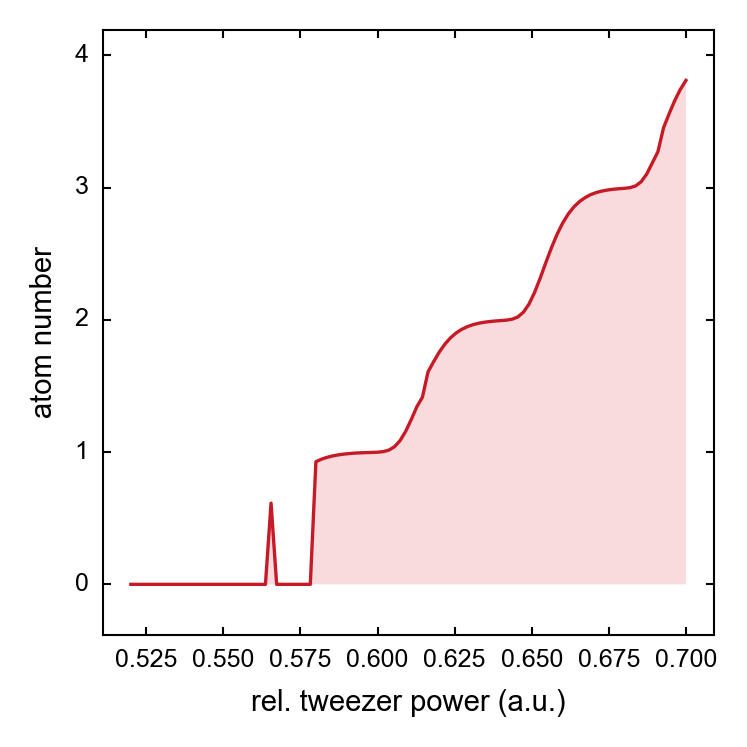

In [24]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("rel. tweezer power (a.u.)")
ax.set_ylabel("atom number")
ax.plot(spill_power_factor, atom_number, marker="None")
ax.fill_between(spill_power_factor, atom_number, fc=colors_alpha["red"], alpha=0.5)

### changing polarisability and increase initial power (n_levels=60 to check for bug)

In [59]:
initial_power = 400 * si.uW

#parameters for lithium setup
wvl = 1064 * si.nm
omega_l = 2 * np.pi * const.c / wvl
omega_0 = 2 * np.pi * const.c / (671 * si.nm)
gamma = 2 * np.pi * 5.8724 * const.mega

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z=15 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer=1.838 * si.um,

    wvl = 1064 * si.nm,
    omega_0 = 2 * np.pi * const.c / (671 * si.nm),
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    m = 6.0151228 * const.value("atomic mass constant"),
    mu_b = const.value("Bohr magneton"),
)
axial_width = trap.get_tweezer_rayleigh()

x, y, z = trap.x, trap.y, trap.z

In [60]:
n_spill_steps = 100

trap[trap.power_tweezer] = initial_power

spill_power_factor = np.linspace(0.7, 0.52, num=n_spill_steps)
powers = trap[trap.power_tweezer] * spill_power_factor
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 100
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))

  0%|          | 0/100 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [03:33<00:13,  1.10it/s]<lambdifygenerated-3051>:2: RuntimeWarning: overflow encountered in scalar power
  return 1.49145373853941e-39*z/(pi**3*(z**2/pi**2 + 1.00808875956951e-11)**2) - 1.391101511745e-24
<lambdifygenerated-3052>:2: RuntimeWarning: overflow encountered in scalar power
  return -5.96581495415766e-39*z**2/(pi**5*(z**2/pi**2 + 1.00808875956951e-11)**3) + 1.49145373853941e-39/(pi**3*(z**2/pi**2 + 1.00808875956951e-11)**2)
c:\Users\peter\AppData\Local\anaconda3\Lib\site-packages\scipy\optimize\_root_scalar.py:326: RuntimeWarning: Derivative was zero.
  r, sol = methodc(f, x0, args=args, fprime=fprime, fprime2=fprime2, **kwargs)
<lambdifygenerated-3050>:3: RuntimeWarning: overflow encountered in scalar multiply
  return 7.3974326386514e-29*x0 - 7.3974326386514e-29*x0/(99197614347.6731*z**2/pi**2 + 1) - 1.391101511745e-24*z
 86%|████████▌ | 86/100 [03:34<00:11,  1.26it/s]<lambdifygenerated-3056>:2: RuntimeWarning: overflow encountered in scalar power
 

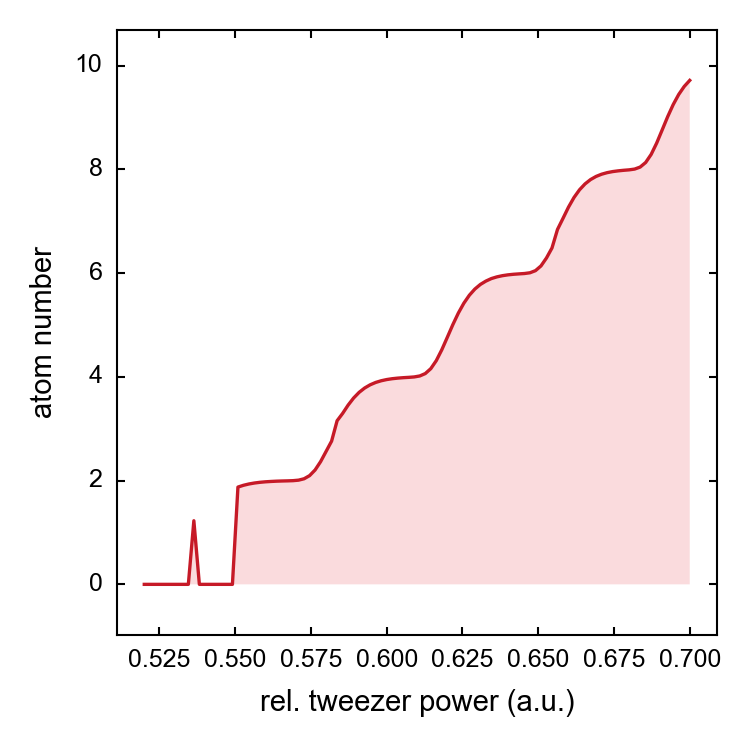

In [14]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("rel. tweezer power (a.u.)")
ax.set_ylabel("atom number")
ax.plot(spill_power_factor, atom_number, marker="None")
ax.fill_between(spill_power_factor, atom_number, fc=colors_alpha["red"], alpha=0.5)

#### n_levels=100

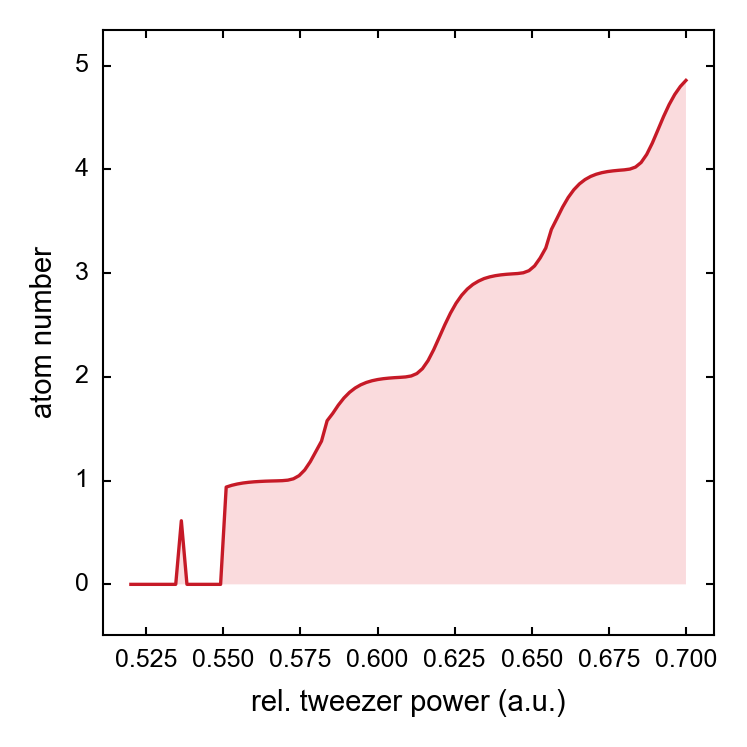

In [61]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("rel. tweezer power (a.u.)")
ax.set_ylabel("atom number")
ax.plot(spill_power_factor, atom_number, marker="None")
ax.fill_between(spill_power_factor, atom_number, fc=colors_alpha["red"], alpha=0.5)

#### Plot potential for these parameters

-7.030454907724839e-30


Text(0, 0.5, 'E / h (kHz)')

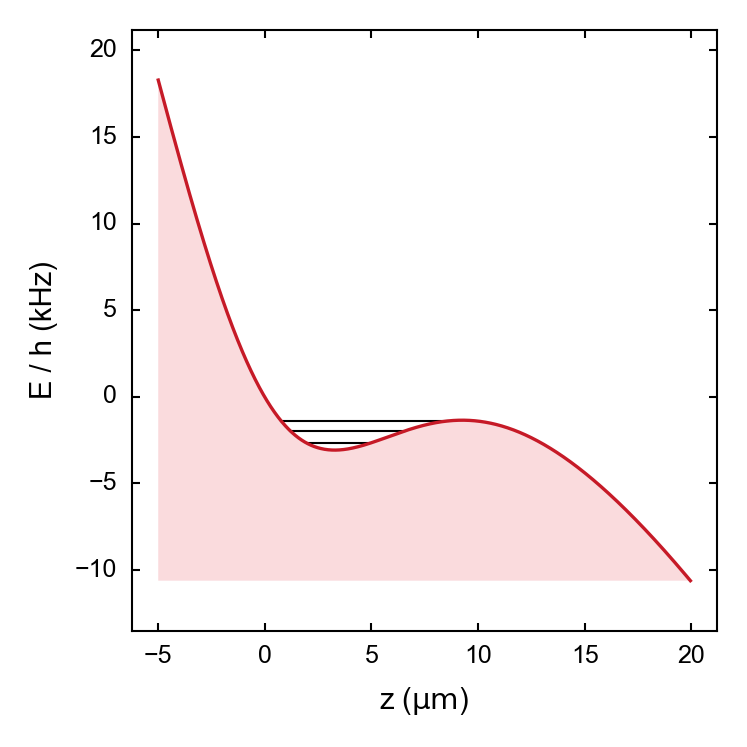

In [62]:
trap[trap.power_tweezer] = 0.6 * initial_power
# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.z, (-0.5 * axial_width, 3 * axial_width), n_pot_steps, k=n_levels
)

pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.z)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

barrier = root_scalar(
    pot_diff_ax_numpy,
    x0=1.5 * float(trap.subs(axial_width)),
    fprime=pot_diff2_ax_numpy,
    xtol=1e-18,
    fprime2=pot_diff2_ax_numpy,
).root

# States that are below the potential barrier
bound_states = energies < potential(barrier)


# Density of states is larger on the left than on the right
# Likely that the state in question is a true bound state
true_bound_states = np.logical_and(
    bound_states,
    np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
    > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
)

width_np = float(trap.subs(axial_width))

z_np = np.linspace(-0.5 * width_np, 2 * width_np, num=1000)

ax: plt.Axes
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# ax.set_title("Axial")
abs_min = np.min(potential(z_np))
print(abs_min)
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    fc=colors_alpha["red"],
    alpha=0.5,
)
# ax2 = ax.twinx()

for i, bound in enumerate(true_bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)) & (z_np < barrier),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    # ax1.plot(coords[trap.z], state**2, marker="None", c="k")

ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz, marker="None")
ax.set_xlabel(r"z ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")

### Change mass and magnetic moment, adjust initial power (n_levels=60 to check for bug)

In [91]:
initial_power = 3500 * si.uW

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 15 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer=1.838 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,    
)
axial_width = trap.get_tweezer_rayleigh()

x, y, z = trap.x, trap.y, trap.z

In [3]:
n_spill_steps = 50

trap[trap.power_tweezer] = initial_power

spill_power_factor = np.linspace(0.65, 0.63, num=n_spill_steps)
powers = trap[trap.power_tweezer] * spill_power_factor
t_spill = 25 * si.ms
atom_number = np.zeros_like(powers)

# Number of energy levels to compute
# will change over time to avoid calculating too many levels
n_levels = 100
# Resolution of the potential when solving numerically
n_pot_steps = 1000

for i, power in enumerate(tqdm(powers)):
    trap[trap.power_tweezer] = power
    # Solve the hamiltonian numerically in axial direction
    energies, states, potential, coords = trap.nstationary_solution(
        trap.z, (-0.5 * axial_width, 1.8 * axial_width), n_pot_steps, k=n_levels
    )

    # Determine the potential and its derivatives
    pot_ax = trap.subs(trap.get_potential())
    pot_diff_ax = sp.diff(pot_ax, trap.z)
    pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
    pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
    pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
    pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
    pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

    barrier = root_scalar(
        pot_diff_ax_numpy,
        x0=1.5 * float(trap.subs(axial_width)),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root
    # States that are below the potential barrier
    bound_states = energies < potential(barrier)

    n_bound_states = np.sum(bound_states)
    n_levles = n_bound_states + 3  # add 3 more levels to be safe

    # Density of states is larger on the left than on the right
    # Likely that the state in question is a true bound state
    true_bound_states = np.logical_and(
        bound_states,
        np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
        > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
    )

    transmission_probability = np.full_like(energies, np.nan, dtype=float)
    for j, energy in enumerate(energies):
        if not true_bound_states[j]:
            continue
        intersect_end = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(barrier, 3 * float(trap.subs(axial_width))),
        ).root
        intersect_start = root_scalar(
            lambda x: potential(x) - energy,
            bracket=(minimum, barrier),
        ).root
        barrier_interval = np.logical_and(
            coords[z] > intersect_start, coords[z] < intersect_end
        )
        s = quad(
            lambda x: np.sqrt(
                2
                * float(trap.subs(trap.m))
                * np.clip(potential(x) - energy, a_min=0, a_max=None)
            )
            / const.hbar,
            intersect_start,
            intersect_end,
        )
        transmission_probability[j] = sp.exp(-2 * s[0])
    tunneling_rate = (
        transmission_probability * np.abs(energies - potential(minimum)) / const.h
    )
    atom_number[i] = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))

  6%|▌         | 3/50 [01:01<15:57, 20.38s/it]


KeyboardInterrupt: 

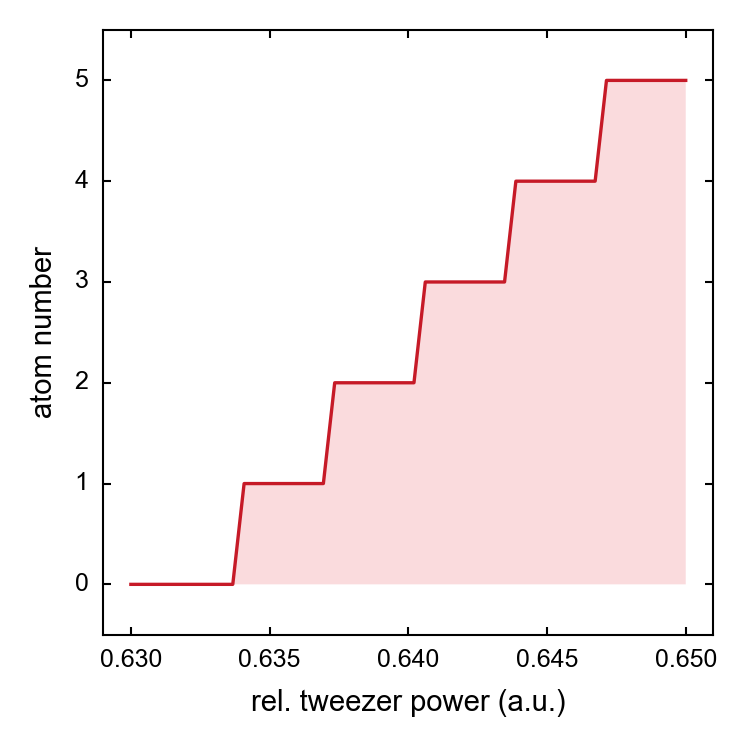

In [54]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("rel. tweezer power (a.u.)")
ax.set_ylabel("atom number")
ax.plot(spill_power_factor, atom_number, marker="None")
ax.fill_between(spill_power_factor, atom_number, fc=colors_alpha["red"], alpha=0.5)

#### n_levels=100

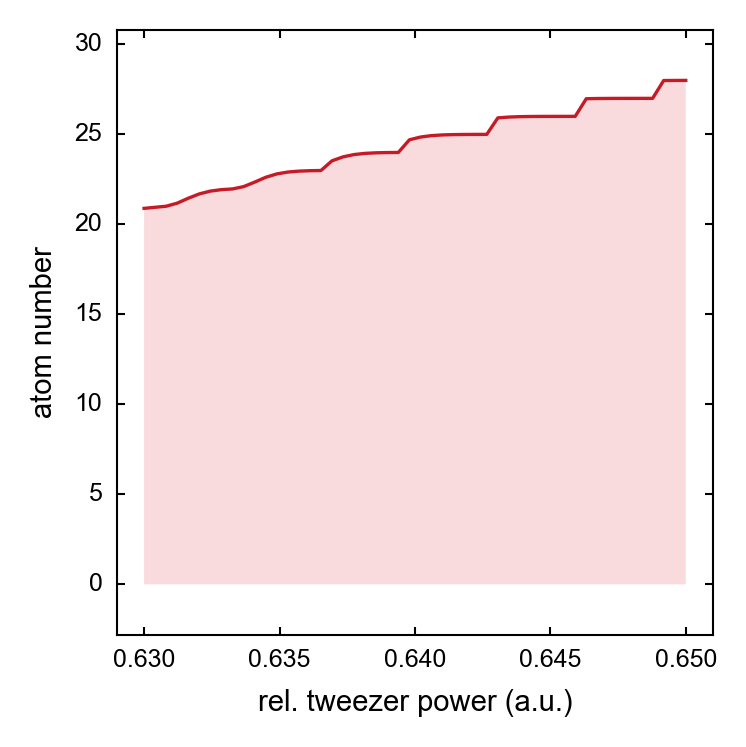

In [58]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.set_xlabel("rel. tweezer power (a.u.)")
ax.set_ylabel("atom number")
ax.plot(spill_power_factor, atom_number, marker="None")
ax.fill_between(spill_power_factor, atom_number, fc=colors_alpha["red"], alpha=0.5)

#### Plot potential for these parameters

0
-1.2215042174494931e-28


Text(0, 0.5, 'E / h (kHz)')

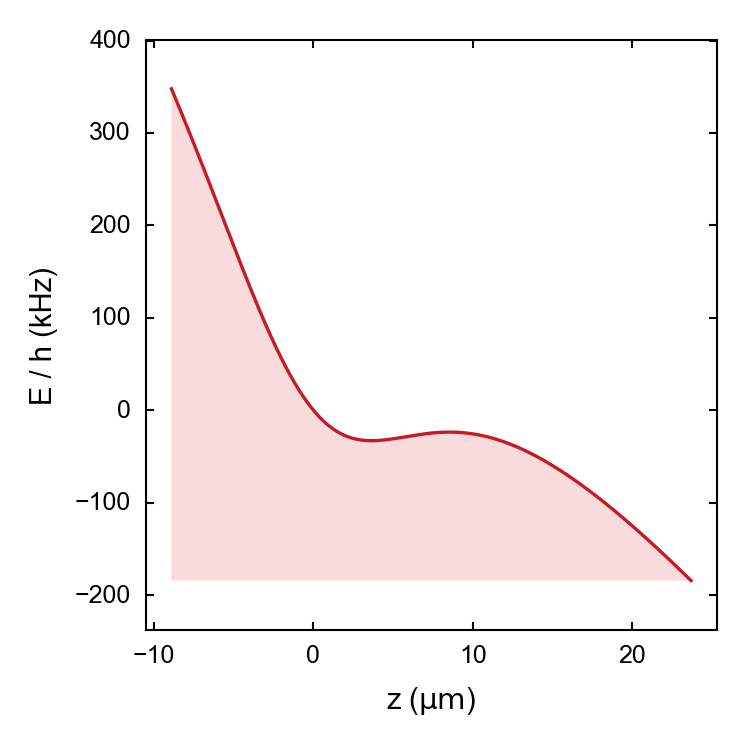

In [53]:
n_pot_steps = 1000
n_levels = 500

pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.z)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

barrier = root_scalar(
    pot_diff_ax_numpy,
    x0=1.5 * float(trap.subs(axial_width)),
    fprime=pot_diff2_ax_numpy,
    xtol=1e-18,
    fprime2=pot_diff3_ax_numpy,
).root

minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff3_ax_numpy,
    ).root


pot_min_ax_numpy = sp.lambdify(trap.z,pot_ax.subs({x: 0, y: 0}) - potential(minimum))
right_cutoff = root_scalar(
        pot_min_ax_numpy,
        x0=barrier + np.abs(barrier - minimum),
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff3_ax_numpy,
    ).root
right_cutoff = barrier + np.abs(barrier - minimum)
left_cutoff = minimum - np.abs(barrier - minimum)

trap[trap.power_tweezer] = 0.64 * initial_power
# Solve the hamiltonian numerically in axial direction
energies, states, potential, coords = trap.nstationary_solution(
    trap.z, (left_cutoff, right_cutoff), n_pot_steps, k=n_levels
)

# States that are below the potential barrier
bound_states = energies < potential(barrier)


# Density of states is larger on the left than on the right
# Likely that the state in question is a true bound state
true_bound_states = np.logical_and(
    bound_states,
    np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
    > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
)
print(np.sum(true_bound_states))

width_np = float(trap.subs(axial_width))

z_np = np.linspace(left_cutoff, right_cutoff, num=1000)

ax: plt.Axes
fig, ax = plt.subplots(figsize=(2.5, 2.5))
# ax.set_title("Axial")
abs_min = np.min(potential(z_np))
print(abs_min)
ax.fill_between(
    z_np / si.um,
    potential(z_np) / const.h / si.kHz,
    abs_min / const.h / si.kHz,
    fc=colors_alpha["red"],
    alpha=0.5,
)
# ax2 = ax.twinx()

for i, bound in enumerate(true_bound_states):
    if not bound:
        continue
    energy = energies[i]
    state = states[i]
    ax.plot(
        z_np / si.um,
        np.where(
            (energy > potential(z_np)) & (z_np < barrier),
            energy / const.h / si.kHz,
            np.nan,
        ),
        c="k",
        lw=0.5,
        marker="None",
    )
    ax.plot(z_np/si.um, state**2 *600, marker="None", c="k")

ax.plot(z_np / si.um, potential(z_np) / const.h / si.kHz, marker="None")
ax.set_xlabel(r"z ($\mathrm{\mu m}$)")
ax.set_ylabel(r"E / h (kHz)")

In [56]:
from scipy.signal import argrelmax,argrelmin

In [ ]:
z_in = np.linspace(-1.5* float(trap.subs(axial_width)),3* float(trap.subs(axial_width)),1000)
potential_z = sp.lambdify(trap.z, pot_ax.subs({x: 0, y: 0}))(z_in)
mi = z_in[argrelmin(test)]
mi

array([1.97696491e-06])

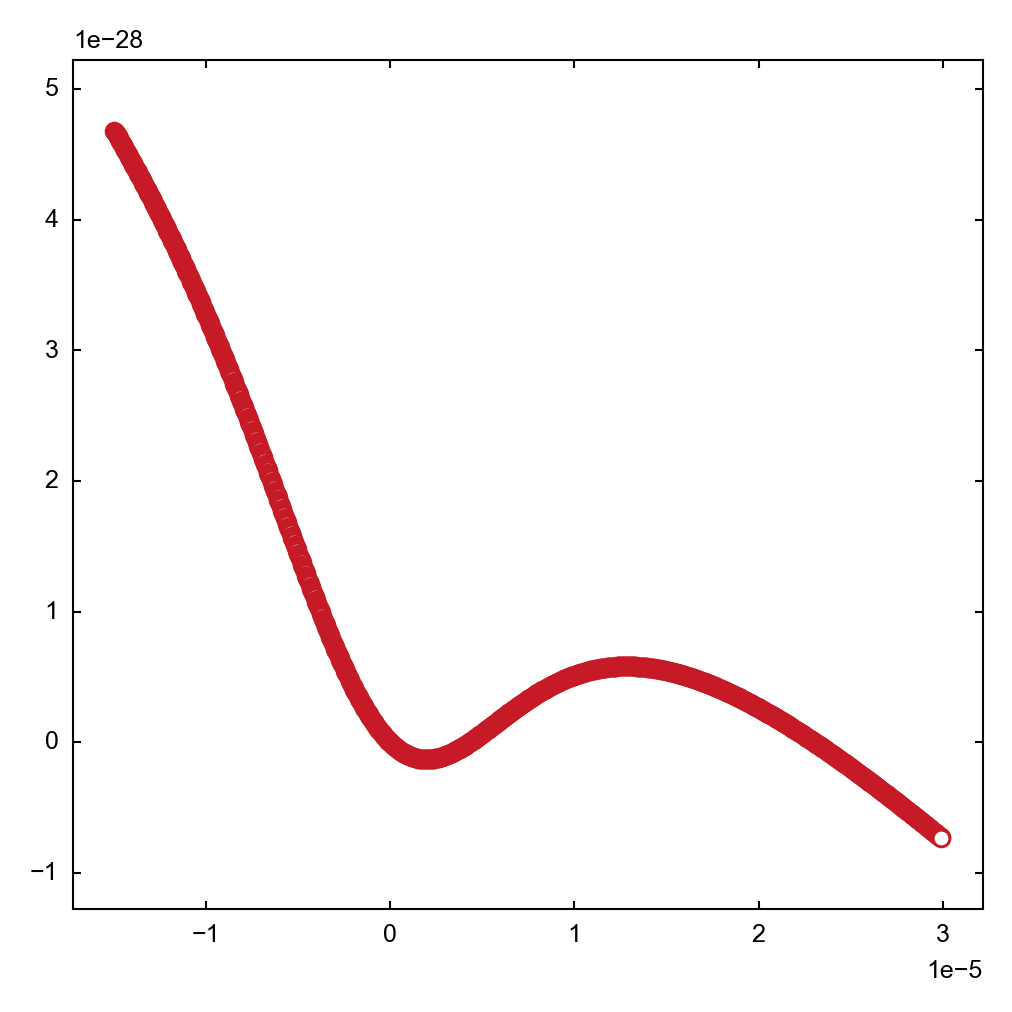

In [88]:
plt.plot(z_in,test)

In [125]:
initial_power = 3500 * si.uW

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 5 * si.G / si.cm,
    grad_r=0,
    power_tweezer=initial_power,
    waist_tweezer=1.838 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,    
)
axial_width = trap.get_tweezer_rayleigh()

x, y, z = trap.x, trap.y, trap.z

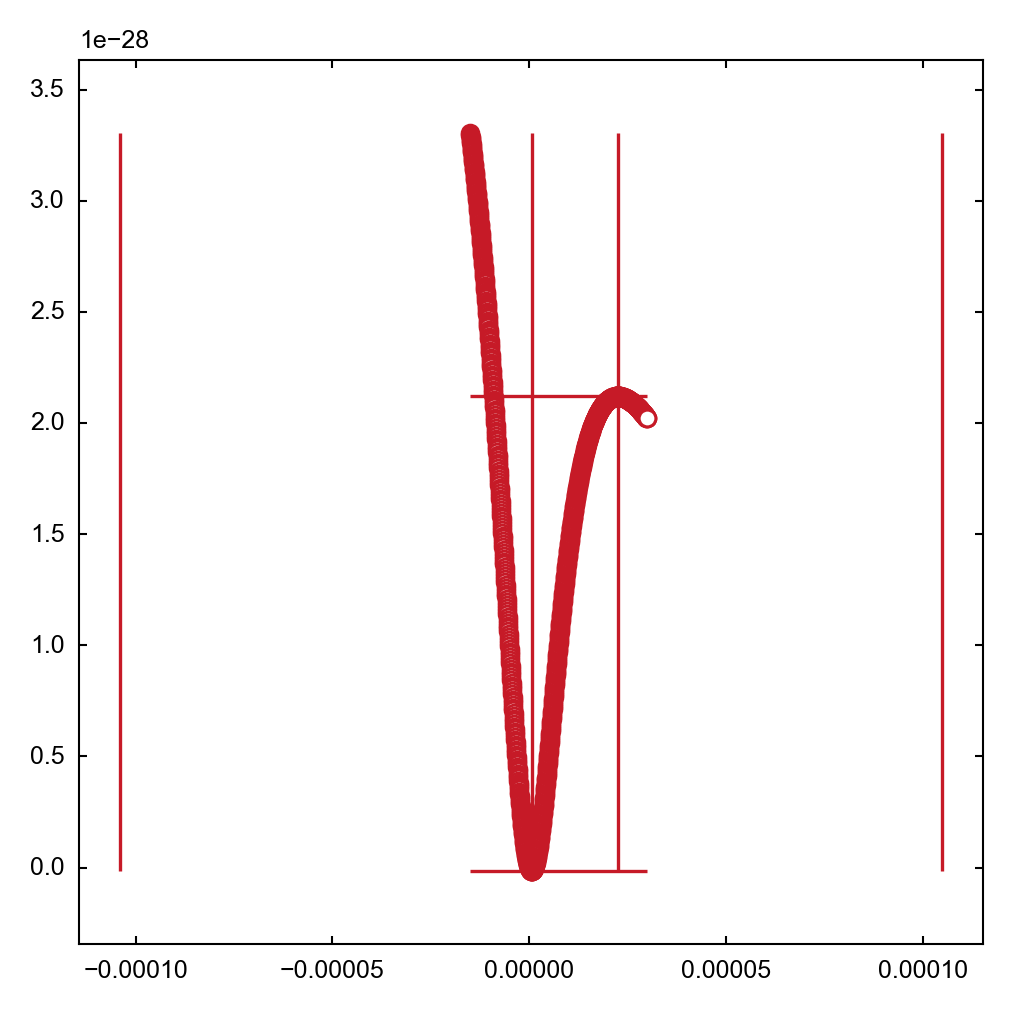

In [126]:
n_pot_steps = 1000
n_levels = 500

#get potential minimum and maximum
pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.z)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))

z_in = np.linspace(-1.5* float(trap.subs(axial_width)),3* float(trap.subs(axial_width)),n_pot_steps)
potential_in = sp.lambdify(trap.z, pot_ax.subs({x: 0, y: 0}))(z_in)
barrier = z_in[argrelmax(potential_in)][0]
E_max = potential_in[argrelmax(potential_in)][0]
minimum = z_in[argrelmin(potential_in)][0]
E_min = potential_in[argrelmin(potential_in)][0]

#get cutoff values for solving SE
pot_min_ax_numpy = sp.lambdify(trap.z,pot_ax.subs({x: 0, y: 0}) - (E_min - 0.5*np.abs(E_max-E_min)) )
right_cutoff = root_scalar(
        pot_min_ax_numpy,
        x0=barrier + np.abs(barrier - minimum),
        fprime=pot_diff_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root

pot_min_ax_numpy = sp.lambdify(trap.z,pot_ax.subs({x: 0, y: 0}) - (E_min + 4*np.abs(E_max-E_min)) )
left_cutoff = root_scalar(
        pot_min_ax_numpy,
        x0=minimum - np.abs(barrier - minimum),
        fprime=pot_diff_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff2_ax_numpy,
    ).root

#plot results
plt.plot(z_in,potential_in)
plt.vlines(barrier,np.min(potential_in),np.max(potential_in))
plt.vlines(minimum,np.min(potential_in),np.max(potential_in))
plt.vlines(left_cutoff,np.min(potential_in),np.max(potential_in))
plt.vlines(right_cutoff,np.min(potential_in),np.max(potential_in))
plt.hlines(E_min,np.min(z_in),np.max(z_in))
plt.hlines(E_max,np.min(z_in),np.max(z_in))

In [105]:
E_min - np.abs(E_max-E_min)

-8.426358471408197e-29